# H2O-CO2 EOS calculations
- DiadFit contains the EOS of Duan and Zhang (2006)
- This code was converted from the C code from  Yoshimura et al. (2023) - we thank them for making such a clear description of the mistakes in the original Duan and Zhang paper!
https://doi.org/10.2465/jmps.221224a
- There are two main types of calculations you might want to do with a mixed EOS. 
1) If you work on fluid inclusions, its nice to assume they are a pure CO$_2$ fluid. But in reality, you probably have some H$_2$O in the fluid phase. You can calculate a pressure for a given XH2O value, assuming the H has been lost .
1) If you are an experimentalist, you probably know P and T, and you have some idea of XH2O. You might want to calculate molar volumes, compressabilities, activities and fugacities. 

In [1]:
# If you havent already - install DiadFit. You need v.80+ to do these calcs.
#!pip install DiadFit --upgrade 

In [2]:
import DiadFit as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

## 1. Correcting fluid inclusions for H$_2$O
- The theory for this is layed out in Hansteen and Klugel (2008). In all but the most anhydrous, deep systems, the exsolved fluid phase will contain some H2O. It is generally assumed that this is lost from the fluid inclusion, so you are left with CO$_2$ you have measured by Raman spectroscopy
- First, you have to calculate the bulk density of the original CO2+H2O mix. Then, using this density, you can use the mixed EOS to calculate pressure. Here, we compare this to pure CO$_2$ EOS. 

### 1a: Correcting a single FI composition
- Say you measured a CO$_2$ density of 0.3, and you think XH2O=0.1 (perhaps based on melt inclusion data - you can get XH2O from VESical)
- Lets compare the calculations

In [3]:
Diff_EOS=pf.calculate_entrapment_P_XH2O(XH2O=0.1, CO2_dens_gcm3=0.3, T_K=1200+273.15)
Diff_EOS

,P_kbar_pureCO2_SW96,P_kbar_pureCO2_SP94,P_kbar_pureCO2_DZ06,P_kbar_mixCO2_DZ06,P Mix/P Pure DZ06,rho_mix_calc,CO2_dens_gcm3,T_K,XH2O
0,1.055698,1.055698,1.052613,1.188251,1.128859,0.313636,0.3,1473.15,0.1


- We can see that the mixed fluid pressure is ~12% higher than doing the pure calculation

### 1b - Visualizing changes across a wider space
- You dont have to feed a single value into this function, you could do an entire spreadsheet of values. 
- Here, lets do calculations for different densities for a range of XH2O values

In [4]:
XH2O=np.linspace(0, 0.2, 50) # 20 evenly spaced XH2O values

df_01=pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=0.1, T_K=1200+273.15)
df_02=pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=0.2, T_K=1200+273.15)
df_03=pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=0.3, T_K=1200+273.15)
df_04=pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=0.4, T_K=1200+273.15)
df_05=pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=0.5, T_K=1200+273.15)
df_07=pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=0.7, T_K=1200+273.15)
df_09=pf.calculate_entrapment_P_XH2O(XH2O=XH2O, CO2_dens_gcm3=0.9, T_K=1200+273.15)

Text(0, 0.5, 'P Mix/P Pure')

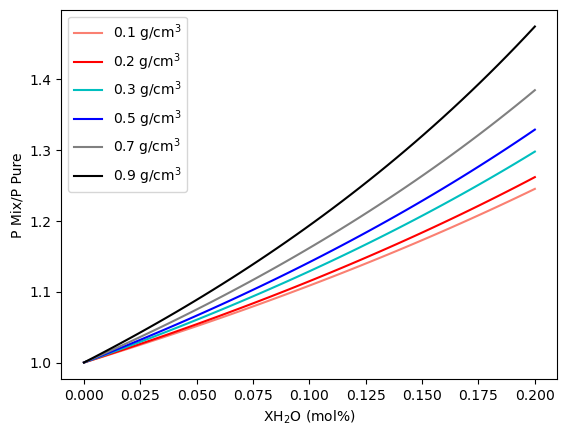

In [5]:
plt.plot(XH2O, df_01['P Mix/P Pure DZ06'], '-', color='salmon', label='0.1 g/cm$^{3}$')
plt.plot(XH2O, df_02['P Mix/P Pure DZ06'], '-r', label='0.2 g/cm$^{3}$')
plt.plot(XH2O, df_03['P Mix/P Pure DZ06'], '-c', label='0.3 g/cm$^{3}$')
plt.plot(XH2O, df_05['P Mix/P Pure DZ06'], '-b', label='0.5 g/cm$^{3}$')
plt.plot(XH2O, df_07['P Mix/P Pure DZ06'], '-', color='grey', label='0.7 g/cm$^{3}$')
plt.plot(XH2O, df_09['P Mix/P Pure DZ06'], '-',  color='k', label='0.9 g/cm$^{3}$')
plt.legend()
plt.xlabel('XH$_2$O (mol%)')
plt.ylabel('P Mix/P Pure')

## 2. Calculations for experimentalists

In [6]:
## Lets load in a spreadsheet of experimental conditions
df=pd.read_excel('Exp_Cond.xlsx')
df=pf.calc_prop_knownP_EOS_DZ2006(P_kbar=df['P_kbar'], T_K=df['T_K'], XH2O=df['XH2O'])
df.head()


,P_kbar,T_K,XH2O,XCO2,Molar Volume (cm3/mol),Density (g/cm3),Compressability_factor,fugacity_H2O (kbar),fugacity_CO2 (kbar),activity_H2O,activity_CO2
0,1.0,1200,0.1,0.9,125.333500,0.330319,1.256179,0.092945,1.163275,0.100954,0.900294
1,2.0,1400,0.2,0.8,86.992117,0.446017,1.494677,0.424996,2.668323,0.213429,0.804635
2,4.0,800,0.0,1.0,45.153235,0.974460,2.715342,0.000000,17.198213,0.000000,1.000000
3,1.0,1500,0.0,1.0,155.085905,0.283714,1.243502,0.000000,1.264244,0.000000,1.000000
4,0.5,1200,1.0,0.0,191.178832,0.094153,0.958063,0.477024,0.000000,1.000000,0.000000


In [7]:
# You can also do the calc for a single condition!
df=pf.calc_prop_knownP_EOS_DZ2006(P_kbar=3, T_K=1400, XH2O=0.2)
df

,P_kbar,T_K,XH2O,XCO2,Molar Volume (cm3/mol),Density (g/cm3),Compressability_factor,fugacity_H2O (kbar),fugacity_CO2 (kbar),activity_H2O,activity_CO2
0,3,1400,0.2,0.8,67.007214,0.579042,1.726952,0.695761,5.283101,0.223567,0.806015
